# О сореве

Это соревнование из ШАДа (МТС) нацеленное на задачу обучения с учителем, задача классфиикации на Kaggle, a.k.a 2 ДЗ по ML

[ссылка на соревнование](https://www.kaggle.com/competitions/teta-ml-1-2025/overview)

# Импорт библиотек

In [31]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import  train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from category_encoders.cat_boost import CatBoostEncoder

from hyperopt import hp, fmin, STATUS_OK, Trials, tpe

import shap
import joblib

# EDA

In [32]:
df = pd.read_csv('train (1).csv')
df

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
0,2019-12-27 15:21,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.0838,-120.6649,60,Museum education officer,45.042827,-120.709327,0
1,2019-04-17 23:09,"fraud_Brown, Homenick and Lesch",health_fitness,39.40,Grace,Williams,F,28812 Charles Mill Apt. 628,Plantersville,AL,36758,32.6176,-86.9475,1412,Drilling engineer,31.872266,-87.828247,0
2,2019-09-23 15:02,fraud_Ruecker-Mayert,kids_pets,52.96,Kyle,Park,M,7507 Larry Passage Suite 859,Mount Perry,OH,43760,39.8788,-82.1880,1831,Barrister's clerk,40.010874,-81.841249,0
3,2019-05-13 16:00,"fraud_Mante, Luettgen and Hackett",health_fitness,7.66,Monique,Martin,F,68276 Matthew Springs,Ratcliff,TX,75858,31.3833,-95.0619,43,"Engineer, production",30.888406,-95.141609,0
4,2019-08-18 07:27,fraud_Luettgen PLC,gas_transport,51.59,Christine,Johnson,F,8011 Chapman Tunnel Apt. 568,Blairsden-Graeagle,CA,96103,39.8127,-120.6405,1725,Chartered legal executive (England and Wales),39.376017,-121.311691,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786426,2019-04-10 12:35,"fraud_O'Connell, Botsford and Hand",home,76.56,Ryan,Foster,M,03921 Cole Mission Suite 882,Hampton,FL,32044,29.8575,-82.1483,2060,Oncologist,29.235257,-82.407844,0
786427,2019-12-15 09:34,"fraud_Adams, Kovacek and Kuhlman",grocery_net,68.58,Jim,Johnson,M,868 Brady Mill Apt. 837,Gretna,LA,70056,29.8872,-90.0331,55581,Biomedical scientist,29.015274,-90.564712,0
786428,2019-10-12 10:22,"fraud_Lind, Huel and McClure",gas_transport,66.66,Christopher,Horn,M,956 Sanchez Highway,Mallie,KY,41836,37.2692,-82.9161,798,Facilities manager,37.515508,-82.443788,0
786429,2019-10-18 09:01,fraud_Rempel PLC,grocery_net,38.06,Samuel,Sandoval,M,0005 Morrison Land,Mounds,OK,74047,35.8896,-96.0887,7163,Fitness centre manager,35.203864,-96.999902,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786431 entries, 0 to 786430
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_time  786431 non-null  object 
 1   merch             786431 non-null  object 
 2   cat_id            786431 non-null  object 
 3   amount            786431 non-null  float64
 4   name_1            786431 non-null  object 
 5   name_2            786431 non-null  object 
 6   gender            786431 non-null  object 
 7   street            786431 non-null  object 
 8   one_city          786431 non-null  object 
 9   us_state          786431 non-null  object 
 10  post_code         786431 non-null  int64  
 11  lat               786431 non-null  float64
 12  lon               786431 non-null  float64
 13  population_city   786431 non-null  int64  
 14  jobs              786431 non-null  object 
 15  merchant_lat      786431 non-null  float64
 16  merchant_lon      78

In [34]:
cat_columns = df.select_dtypes('object')

for i in cat_columns:
    print(f'Уникальность колонки {i} составляет {(df[i].nunique() / len(df[i])) * 100} %')

Уникальность колонки transaction_time составляет 53.38688327392994 %
Уникальность колонки merch составляет 0.08811961888582723 %
Уникальность колонки cat_id составляет 0.0017801943209258026 %
Уникальность колонки name_1 составляет 0.0442505445487271 %
Уникальность колонки name_2 составляет 0.06090807712310425 %
Уникальность колонки gender составляет 0.0002543134744179718 %
Уникальность колонки street составляет 0.12270625140667141 %
Уникальность колонки one_city составляет 0.11177077200669862 %
Уникальность колонки us_state составляет 0.006484993597658282 %
Уникальность колонки jobs составляет 0.06268827144403005 %


## FE

In [35]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

# Извлечение компонентов времени
df['transaction_hour'] = df['transaction_time'].dt.hour
df['transaction_day'] = df['transaction_time'].dt.day
df['transaction_month'] = df['transaction_time'].dt.month
df['transaction_dayofweek'] = df['transaction_time'].dt.dayofweek
df['is_weekend'] = df['transaction_dayofweek'].isin([5, 6]).astype(int)
df['is_night'] = ((df['transaction_hour'] >= 22) | (df['transaction_hour'] <= 6)).astype(int)

In [36]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Вычисление расстояния между двумя точками на Земле"""
    R = 6371  # Радиус Земли в км
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

# Расстояние между местоположением клиента и мерчанта
df['distance_km'] = haversine_distance(
    df['lat'], df['lon'], 
    df['merchant_lat'], df['merchant_lon']
)


In [37]:
# Временные фичи
df['hour_sin'] = np.sin(2 * np.pi * df['transaction_hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['transaction_hour']/24)
df['month_sin'] = np.sin(2 * np.pi * df['transaction_month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['transaction_month']/12)

# Гео-фичи
df['distance_to_merchant'] = np.sqrt(
    (df['lat'] - df['merchant_lat'])**2 + 
    (df['lon'] - df['merchant_lon'])**2
)

In [38]:
# Сезонность и пиковые часы
df['is_rush_hour'] = ((df['transaction_hour'] >= 8) & (df['transaction_hour'] <= 10) | 
                      (df['transaction_hour'] >= 17) & (df['transaction_hour'] <= 19)).astype(int)

df['is_holiday_season'] = df['transaction_month'].isin([11, 12]).astype(int)  # Ноябрь-Декабрь
df['is_end_of_month'] = (df['transaction_day'] >= 25).astype(int)  # Конец месяца

# Комбинированные временные фичи
df['weekend_night'] = (df['is_weekend'] & df['is_night']).astype(int)
df['rush_high_amount'] = (df['is_rush_hour'] & (df['amount'] > df['amount'].median())).astype(int)

In [39]:
# Временные эмбеддинги вместо простых часов
df['time_of_day_embedding'] = (
    np.sin(2 * np.pi * df['transaction_hour']/24) * 
    np.cos(2 * np.pi * df['transaction_dayofweek']/7)
)

# Сезонные циклы высокого порядка
df['seasonal_embedding'] = (
    np.sin(2 * np.pi * df['transaction_month']/12) * 
    np.sin(2 * np.pi * df['transaction_day']/31)
)


In [40]:
# Сезонность + день недели + время суток
df['complex_time_pattern'] = (
    np.sin(2 * np.pi * df['transaction_hour']/24) * 
    np.cos(2 * np.pi * df['transaction_dayofweek']/7) *
    np.sin(2 * np.pi * df['transaction_month']/12)
)


# Циклические эмбеддинги высокой размерности
for period in [24, 168, 744]:  # часы, недели, месяцы
    df[f'time_sin_{period}'] = np.sin(2 * np.pi * df['transaction_hour'] / period)
    df[f'time_cos_{period}'] = np.cos(2 * np.pi * df['transaction_hour'] / period)

,target,count
0,0,781927
1,1,4504


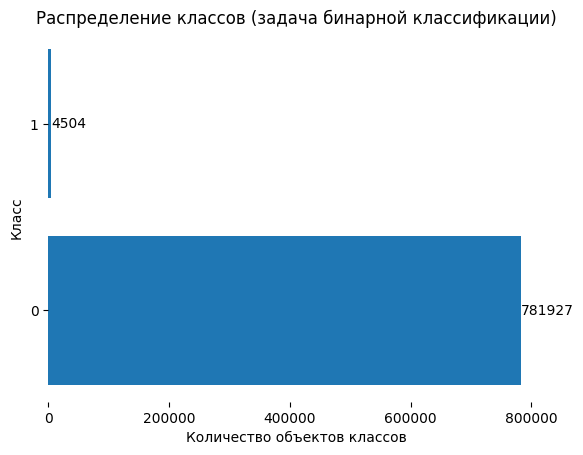

In [41]:
df_1 = df.value_counts('target').reset_index()
display(df_1)


bar_chart = plt.barh(y = df_1['target'], width=df_1['count'])
plt.bar_label(bar_chart, labels=df_1['count'])
plt.yticks([0, 1])
plt.xticks(np.arange(0, 1_000_000, 200_000))
plt.ylabel('Класс')
plt.xlabel('Количество объектов классов')
plt.title('Распределение классов (задача бинарной классификации)')
plt.box(False)

In [43]:
df = df.drop(columns = ['transaction_time', 'street', 'cat_id'])
df

,merch,amount,name_1,name_2,gender,one_city,us_state,post_code,lat,lon,...,rush_high_amount,time_of_day_embedding,seasonal_embedding,complex_time_pattern,time_sin_24,time_cos_24,time_sin_168,time_cos_168,time_sin_744,time_cos_744
0,fraud_Cormier LLC,148.04,Daniel,Martinez,M,Kent,OR,97033,45.0838,-120.6649,...,0,6.370812e-01,1.775230e-16,-1.560399e-16,-7.071068e-01,-0.707107,0.532032,0.846724,0.126339,0.991987
1,"fraud_Brown, Homenick and Lesch",39.40,Grace,Williams,F,Plantersville,AL,36758,32.6176,-86.9475,...,0,5.759266e-02,-2.592561e-01,4.987670e-02,-2.588190e-01,0.965926,0.757972,0.652287,0.193019,0.981195
2,fraud_Ruecker-Mayert,52.96,Kyle,Park,M,Mount Perry,OH,43760,39.8788,-82.1880,...,0,-7.071068e-01,9.987165e-01,7.071068e-01,-7.071068e-01,-0.707107,0.532032,0.846724,0.126339,0.991987
3,"fraud_Mante, Luettgen and Hackett",7.66,Monique,Martin,F,Ratcliff,TX,75858,31.3833,-95.0619,...,0,-8.660254e-01,2.426510e-01,-4.330127e-01,-8.660254e-01,-0.500000,0.563320,0.826239,0.134711,0.990885
4,fraud_Luettgen PLC,51.59,Christine,Johnson,F,Blairsden-Graeagle,CA,96103,39.8127,-120.6405,...,0,6.022449e-01,4.202838e-01,-5.215594e-01,9.659258e-01,-0.258819,0.258819,0.965926,0.059082,0.998253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786426,"fraud_O'Connell, Botsford and Hand",76.56,Ryan,Foster,M,Hampton,FL,32044,29.8575,-82.1483,...,0,-2.725095e-17,7.775215e-01,-2.360002e-17,1.224647e-16,-1.000000,0.433884,0.900969,0.101168,0.994869
786427,"fraud_Adams, Kovacek and Kuhlman",68.58,Jim,Johnson,M,Gretna,LA,70056,29.8872,-90.0331,...,1,4.408739e-01,-2.477909e-17,-1.079830e-16,7.071068e-01,-0.707107,0.330279,0.943883,0.075933,0.997113
786428,"fraud_Lind, Huel and McClure",66.66,Christopher,Horn,M,Mallie,KY,41836,37.2692,-82.9161,...,1,-1.112605e-01,-5.641051e-01,9.635439e-02,5.000000e-01,-0.866025,0.365341,0.930874,0.084351,0.996436
786429,fraud_Rempel PLC,38.06,Samuel,Sandoval,M,Mounds,OK,74047,35.8896,-96.0887,...,0,-6.370812e-01,4.202838e-01,5.517285e-01,7.071068e-01,-0.707107,0.330279,0.943883,0.075933,0.997113


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786431 entries, 0 to 786430
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   merch                  786431 non-null  object 
 1   amount                 786431 non-null  float64
 2   name_1                 786431 non-null  object 
 3   name_2                 786431 non-null  object 
 4   gender                 786431 non-null  object 
 5   one_city               786431 non-null  object 
 6   us_state               786431 non-null  object 
 7   post_code              786431 non-null  int64  
 8   lat                    786431 non-null  float64
 9   lon                    786431 non-null  float64
 10  population_city        786431 non-null  int64  
 11  jobs                   786431 non-null  object 
 12  merchant_lat           786431 non-null  float64
 13  merchant_lon           786431 non-null  float64
 14  target                 786431 non-nu

In [ ]:
# Сначала разделяем данные
X = df.drop(columns='target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Теперь кодируем ТОЛЬКО на тренировочных данных
cat_columns = X_train.select_dtypes('object').columns
catboost_encoders = {}

for col in cat_columns:
    encoder = CatBoostEncoder()
    X_train[col] = encoder.fit_transform(X_train[col], y_train)
    X_test[col] = encoder.transform(X_test[col])
    catboost_encoders[col] = encoder


In [46]:
X_test

,merch,amount,name_1,name_2,gender,one_city,us_state,post_code,lat,lon,...,rush_high_amount,time_of_day_embedding,seasonal_embedding,complex_time_pattern,time_sin_24,time_cos_24,time_sin_168,time_cos_168,time_sin_744,time_cos_744
72003,0.011313,75.59,0.002680,0.004921,0.005291,0.000006,0.007943,68031,41.6414,-96.5232,...,0,0.258819,6.996018e-17,3.169619e-17,0.258819,9.659258e-01,0.037391,0.999301,0.008445,0.999964
431566,0.014723,119.54,0.006719,0.006719,0.005291,0.006719,0.006880,43160,39.5370,-83.4550,...,0,0.161371,6.276890e-01,-1.397514e-01,0.258819,-9.659258e-01,0.399892,0.916562,0.092763,0.995688
2959,0.002187,25.19,0.002518,0.007518,0.006226,0.005428,0.005249,93529,37.7773,-119.0825,...,0,-0.161371,-7.349475e-01,-1.397514e-01,-0.258819,9.659258e-01,0.757972,0.652287,0.193019,0.981195
425249,0.014409,17.90,0.005092,0.001442,0.005291,0.000004,0.007097,12419,41.8467,-74.1038,...,0,-0.214939,7.349475e-01,1.861424e-01,0.965926,2.588190e-01,0.185912,0.982566,0.042213,0.999109
184795,0.000013,59.38,0.006493,0.006993,0.006226,0.006493,0.004758,28314,35.0583,-79.0080,...,0,0.539958,-4.930392e-17,-1.322516e-16,0.866025,5.000000e-01,0.149042,0.988831,0.033774,0.999429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93409,0.002260,45.18,0.002680,0.004652,0.005291,0.004652,0.005069,53801,42.9207,-91.0685,...,0,-0.780262,-2.078579e-16,1.911091e-16,0.866025,-5.000000e-01,0.294755,0.955573,0.067510,0.997719
314175,0.020683,105.11,0.003313,0.017186,0.005291,0.017186,0.007097,13755,42.0716,-75.0152,...,0,0.623490,3.943559e-01,-6.234898e-01,1.000000,6.123234e-17,0.222521,0.974928,0.050649,0.998717
176292,0.004389,56.51,0.010004,0.007134,0.005291,0.005231,0.005249,94971,38.2427,-122.9145,...,1,-0.450484,-1.006493e-01,-2.252422e-01,0.500000,-8.660254e-01,0.365341,0.930874,0.084351,0.996436
778434,0.007234,53.20,0.006236,0.005654,0.005291,0.006236,0.006691,3816,43.6849,-71.2551,...,0,-0.780262,4.840386e-01,-3.901310e-01,0.866025,5.000000e-01,0.149042,0.988831,0.033774,0.999429


# Подбор гиперпараметров

In [ ]:
def objective_catboost(params):
    params = {
        'iterations': int(params['iterations']),
        'learning_rate': float(params['learning_rate']),
        'depth': int(params['depth']),
        'l2_leaf_reg': float(params['l2_leaf_reg']),
        'random_strength': float(params['random_strength']),
        'verbose': False,
        'random_state': 42
    }
    
    model = CatBoostClassifier(**params)
    
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
    
    loss = -score.mean()
    
    return {'loss': loss, 'status': STATUS_OK, 'params': params}


space_catboost = {
    'iterations': hp.quniform('iterations', 500, 3000, 100),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'depth': hp.quniform('depth', 4, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'random_strength': hp.uniform('random_strength', 0.1, 2)
}


trials = Trials()
best_catboost = fmin(
    fn=objective_catboost,
    space=space_catboost, 
    algo=tpe.suggest,
    max_evals=3, 
    trials=trials,
    verbose=True
)

print("Лучшие параметры:", best_catboost)

In [ ]:
def objective_xgb(params):
    params = {
        'n_estimators': int(params['n_estimators']),  
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42
    }
    
    model = XGBClassifier(**params, verbosity=0)
    
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
    
    loss = -scores.mean()
    
    return {'loss': loss, 'status': STATUS_OK, 'params': params}

# ПОЛНЫЙ SPACE ДЛЯ XGBOOST
xgb_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 2000, 50),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(10))
}

trials = Trials()

best_xgb = fmin(
    fn=objective_xgb,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=8,
    trials=trials,
    verbose=True
)

print("Лучшие параметры XGBoost:", best_xgb)

In [ ]:
# ПРЕОБРАЗОВАНИЕ ПАРАМЕТРОВ ПОСЛЕ ОПТИМИЗАЦИИ
best_xgb = {
    'n_estimators': int(best_xgb['n_estimators']),  
    'learning_rate': best_xgb['learning_rate'],
    'max_depth': int(best_xgb['max_depth']),
    'min_child_weight': best_xgb['min_child_weight'],
    'subsample': best_xgb['subsample'],
    'colsample_bytree': best_xgb['colsample_bytree'],
    'reg_alpha': best_xgb['reg_alpha'],
    'reg_lambda': best_xgb['reg_lambda'],
    'random_state': 42
}

print("Лучшие параметры XGBoost:", best_xgb)

In [ ]:
def objective_lgb(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'min_child_samples': int(params['min_child_samples']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42
    }
    
    model = LGBMClassifier(**params, verbose=-1)
    
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
    
    return {'loss': -scores.mean(), 'status': STATUS_OK, 'params': params}

lgb_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 2000, 50),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 5),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'min_child_samples': hp.quniform('min_child_samples', 10, 100, 5),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(10))
}

best_lgb = fmin(fn=objective_lgb, space=lgb_space, algo=tpe.suggest, max_evals=10, verbose=True)
print(best_lgb)

In [ ]:
best_lgb = {
    'n_estimators': int(best_lgb['n_estimators']),
    'learning_rate': float(best_lgb['learning_rate']),
    'num_leaves': int(best_lgb['num_leaves']),
    'max_depth': int(best_lgb['max_depth']),
    'min_child_samples': int(best_lgb['min_child_samples']),
    'subsample': float(best_lgb['subsample']),
    'colsample_bytree': float(best_lgb['colsample_bytree']),
    'reg_alpha': float(best_lgb['reg_alpha']),
    'reg_lambda': float(best_lgb['reg_lambda']),
    'random_state': 42,
    'verbose': -1
}

print(best_lgb)

# Обучение мета-моделей

## Применяем лучшие гиперпараеры

In [47]:
best_catboost = {'depth': 9, 'iterations': 1900.0, 'l2_leaf_reg': 2.4496295981610574, 'learning_rate': 0.03535844726832339, 'random_strength': 1.593434559660419}
best_xgb = {'n_estimators': 650, 'learning_rate': 0.013186227026987973, 'max_depth': 10, 'min_child_weight': 1.0, 'subsample': 0.8154012654276044, 'colsample_bytree': 0.9716944773200387, 'reg_alpha': 0.0018082541414516933, 'reg_lambda': 0.35014632667779566, 'random_state': 42}
best_lgb = {'colsample_bytree': 0.8874892081048805, 'learning_rate': 0.03709177484279944, 'max_depth': 8, 'min_child_samples': 65, 'n_estimators': 550, 'num_leaves': 35, 'reg_alpha': 0.024356813543404424, 'reg_lambda': 0.0019162175534499011, 'subsample': 0.9177540854710272}


In [48]:
model_1 = CatBoostClassifier(**best_catboost, verbose = 0)
model_2 = XGBClassifier(**best_xgb, verbose = 0)
model_3 = LGBMClassifier(**best_lgb, verbosity = 0)

models = [model_1, model_2, model_3]

for i in models:
    model_name = i.__class__.__name__
    print(f'Обучение модели {model_name}')
    i.fit(X_train, y_train)

    pred = i.predict(X_test)
    print(f'Модель {model_name} получила f1-score {f1_score(pred, y_test)}')

    joblib.dump(i, f'{model_name}_params.pkl')

    #explainer = shap.TreeExplainer(i)

    #shap_values = explainer.shap_values(X_test)

    #plt.title(f'Feature Importance для модели {model_name}')
    #shap.summary_plot(shap_values, X_test, plot_type = 'bar')
 

Обучение модели CatBoostClassifier
Модель CatBoostClassifier получила f1-score 0.7094291212315587
Обучение модели XGBClassifier


c:\Users\Smart\PycharmProjects\Data_analysis\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Модель XGBClassifier получила f1-score 0.7167630057803468
Обучение модели LGBMClassifier
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Модель LGBMClassifier получила f1-score 0.6926461345065996


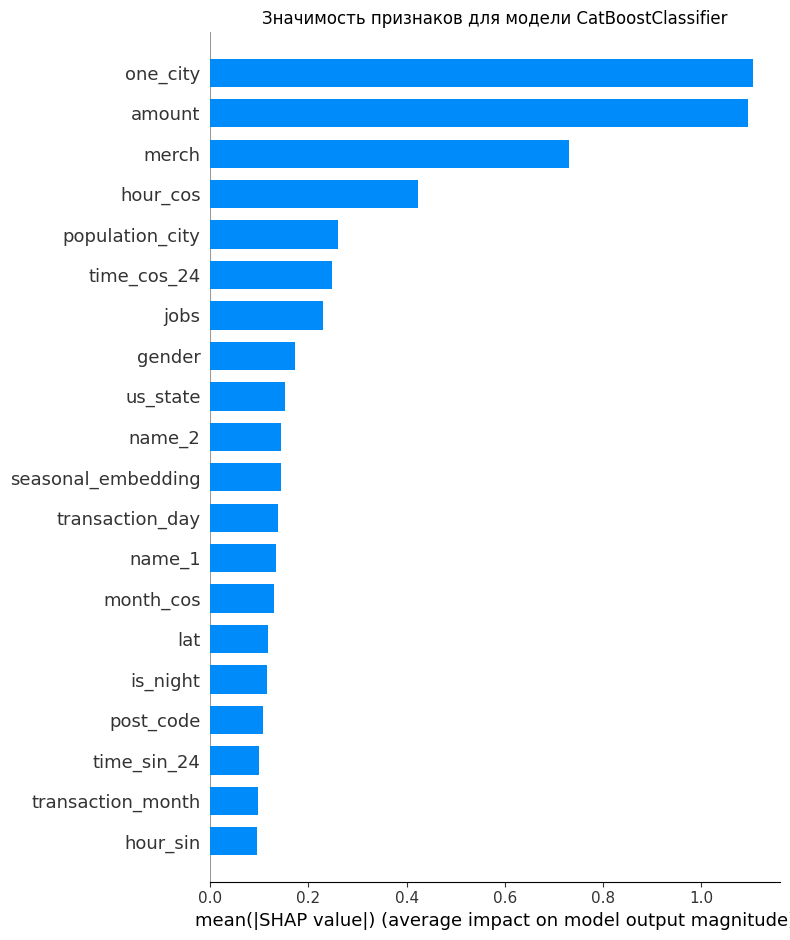

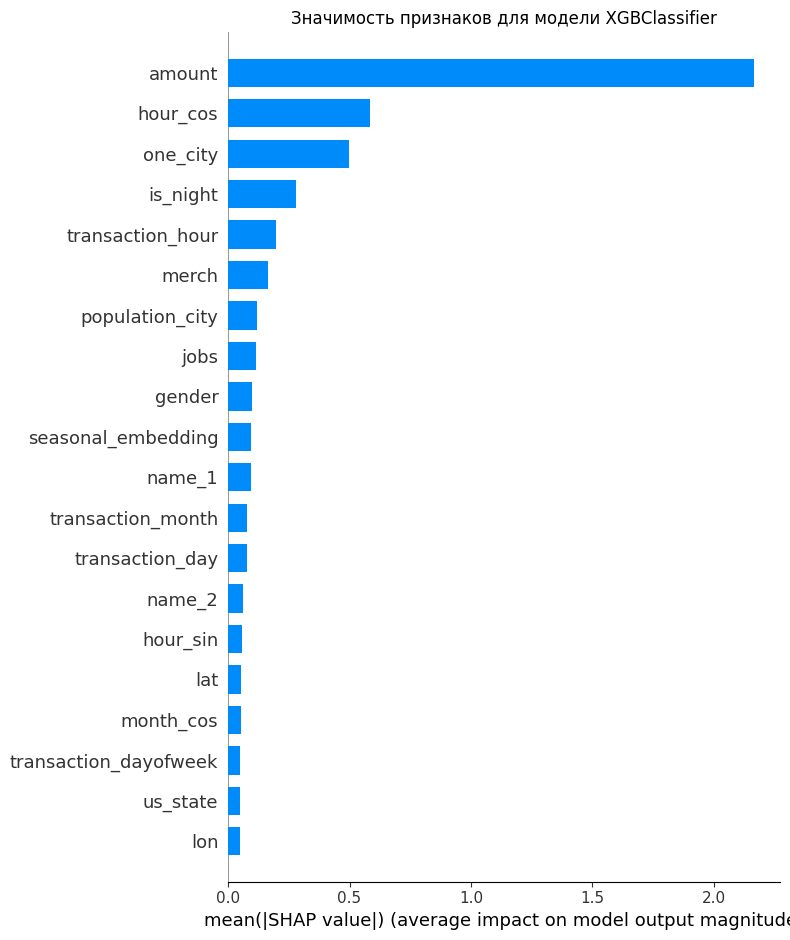

c:\Users\Smart\PycharmProjects\Data_analysis\.venv\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


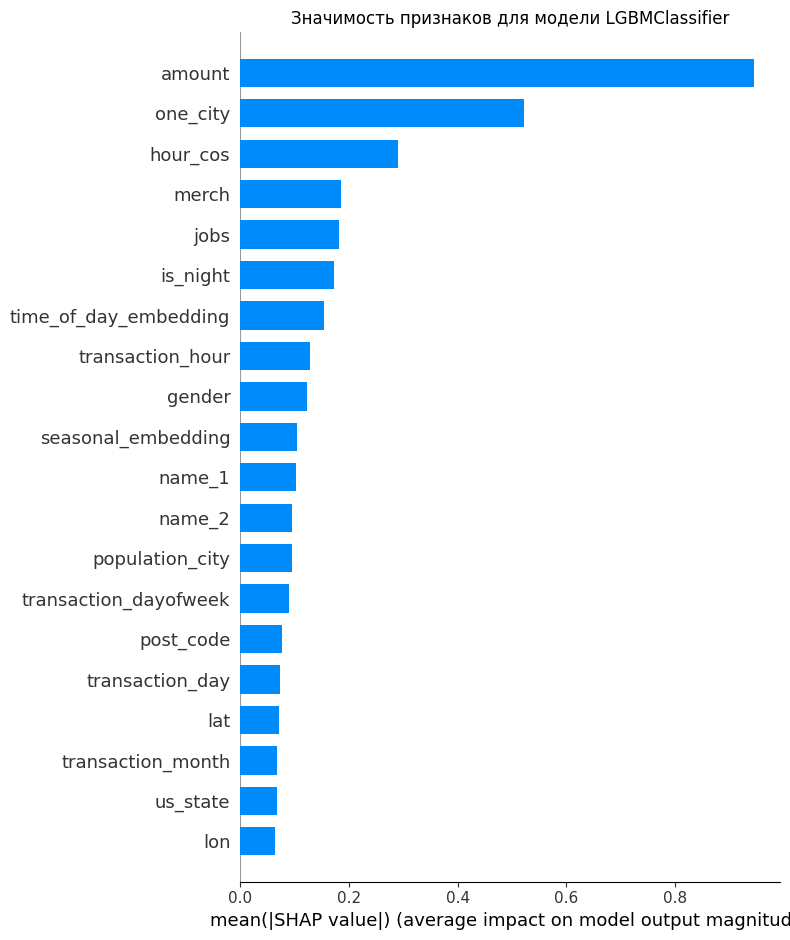

In [135]:
models = [model_1, model_2, model_3]

for i in models:
    explainer = shap.TreeExplainer(i)
    shap_vals = explainer.shap_values(X_test)
    plt.title(f'Значимость признаков для модели {i.__class__.__name__}')
    shap.summary_plot(shap_vals, X_test, plot_type = 'bar')

# Обучение стекинга

In [75]:

final_model = StackingClassifier(
    estimators=[
        ('cat', model_1),
        ('xgb', model_2),
        ('lgb', model_3),
        ],
                cv = 3,
                verbose=0,
                final_estimator=LogisticRegression(),
                passthrough=False, # обучается только на фичах в виде мета-моделей
                stack_method='predict_proba' # использовать вероятности вместо предсказаний
)

final_model.fit(X_train, y_train)
pred_y = final_model.predict(X_test)


print(f'Метрика f1 у стекинга составила {f1_score(pred_y, y_test)}')


c:\Users\Smart\PycharmProjects\Data_analysis\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:12:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\Smart\PycharmProjects\Data_analysis\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:34:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Smart\PycharmProjects\Data_analysis\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:35:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Smart\PycharmProjects\Data_analysis\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:36:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

# Предобработка test.csv

In [122]:
df_test = pd.read_csv('test (1).csv')
df_test

df = df_test

In [123]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

# Извлечение компонентов времени
df['transaction_hour'] = df['transaction_time'].dt.hour
df['transaction_day'] = df['transaction_time'].dt.day
df['transaction_month'] = df['transaction_time'].dt.month
df['transaction_dayofweek'] = df['transaction_time'].dt.dayofweek
df['is_weekend'] = df['transaction_dayofweek'].isin([5, 6]).astype(int)
df['is_night'] = ((df['transaction_hour'] >= 22) | (df['transaction_hour'] <= 6)).astype(int)

In [124]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Вычисление расстояния между двумя точками на Земле"""
    R = 6371  # Радиус Земли в км
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

# Расстояние между местоположением клиента и мерчанта
df['distance_km'] = haversine_distance(
    df['lat'], df['lon'], 
    df['merchant_lat'], df['merchant_lon']
)


In [125]:
# Временные фичи
df['hour_sin'] = np.sin(2 * np.pi * df['transaction_hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['transaction_hour']/24)
df['month_sin'] = np.sin(2 * np.pi * df['transaction_month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['transaction_month']/12)

# Гео-фичи
df['distance_to_merchant'] = np.sqrt(
    (df['lat'] - df['merchant_lat'])**2 + 
    (df['lon'] - df['merchant_lon'])**2
)

In [126]:
# Сезонность и пиковые часы
df['is_rush_hour'] = ((df['transaction_hour'] >= 8) & (df['transaction_hour'] <= 10) | 
                      (df['transaction_hour'] >= 17) & (df['transaction_hour'] <= 19)).astype(int)

df['is_holiday_season'] = df['transaction_month'].isin([11, 12]).astype(int)  # Ноябрь-Декабрь
df['is_end_of_month'] = (df['transaction_day'] >= 25).astype(int)  # Конец месяца

# Комбинированные временные фичи
df['weekend_night'] = (df['is_weekend'] & df['is_night']).astype(int)
df['rush_high_amount'] = (df['is_rush_hour'] & (df['amount'] > df['amount'].median())).astype(int)

In [127]:
# Временные эмбеддинги вместо простых часов
df['time_of_day_embedding'] = (
    np.sin(2 * np.pi * df['transaction_hour']/24) * 
    np.cos(2 * np.pi * df['transaction_dayofweek']/7)
)

# Сезонные циклы высокого порядка
df['seasonal_embedding'] = (
    np.sin(2 * np.pi * df['transaction_month']/12) * 
    np.sin(2 * np.pi * df['transaction_day']/31)
)


In [128]:
# Сезонность + день недели + время суток
df['complex_time_pattern'] = (
    np.sin(2 * np.pi * df['transaction_hour']/24) * 
    np.cos(2 * np.pi * df['transaction_dayofweek']/7) *
    np.sin(2 * np.pi * df['transaction_month']/12)
)


# Циклические эмбеддинги высокой размерности
for period in [24, 168, 744]:  # часы, недели, месяцы
    df[f'time_sin_{period}'] = np.sin(2 * np.pi * df['transaction_hour'] / period)
    df[f'time_cos_{period}'] = np.cos(2 * np.pi * df['transaction_hour'] / period)

In [129]:
df = df.drop(columns = ['transaction_time', 'street', 'cat_id'])
df

,merch,amount,name_1,name_2,gender,one_city,us_state,post_code,lat,lon,...,rush_high_amount,time_of_day_embedding,seasonal_embedding,complex_time_pattern,time_sin_24,time_cos_24,time_sin_168,time_cos_168,time_sin_744,time_cos_744
0,"fraud_Stokes, Christiansen and Sipes",25.79,Michael,Rodriguez,M,Cross Plains,TX,76443,32.1482,-99.1872,...,0,-0.111260,-2.993631e-01,1.112605e-01,0.500000,0.866025,0.074730,0.997204,0.016889,0.999857
1,fraud_Thompson-Gleason,87.80,Curtis,Young,M,Falconer,NY,14733,42.1239,-79.1895,...,0,0.780262,4.688761e-01,-3.901310e-01,-0.866025,0.500000,0.680173,0.733052,0.168101,0.985770
2,fraud_Friesen Inc,10.98,Brandy,Quinn,F,Altair,TX,77412,29.6047,-96.5249,...,0,-0.602245,4.243221e-01,-3.011225e-01,-0.965926,-0.258819,0.593820,0.804598,0.143075,0.989712
3,"fraud_Jenkins, Hauck and Friesen",71.97,Ashley,Mcdonald,F,Marietta,SC,29661,35.0296,-82.5136,...,0,0.000000,4.489023e-01,-0.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
4,"fraud_Kovacek, Dibbert and Ondricka",210.50,Kimberly,Rice,F,Tyler,TX,75703,32.2768,-95.3031,...,0,-0.000000,4.853020e-01,-0.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262139,fraud_O'Keefe-Wisoky,17.39,Scott,Martin,M,Freedom,WY,83120,43.0172,-111.0292,...,0,-0.440874,-4.202838e-01,3.818080e-01,-0.707107,0.707107,0.707107,0.707107,0.176420,0.984315
262140,"fraud_Runolfsdottir, Mueller and Hand",5.29,Chris,White,M,Bessemer,AL,35022,33.3224,-86.9657,...,0,0.780262,1.595402e-16,-1.911091e-16,-0.866025,-0.500000,0.563320,0.826239,0.134711,0.990885
262141,fraud_Dietrich-Fadel,72.75,Katherine,Tucker,F,Lakeland,FL,33811,27.9865,-82.0139,...,0,-0.311745,2.856341e-01,1.558725e-01,-0.500000,-0.866025,0.500000,0.866025,0.117957,0.993019
262142,fraud_Kunze Inc,50.14,Nathan,Mendoza,M,Espanola,NM,87533,35.9866,-106.0654,...,1,-0.111260,-6.276890e-01,-9.635439e-02,0.500000,-0.866025,0.365341,0.930874,0.084351,0.996436


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 40 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   merch                  262144 non-null  object 
 1   amount                 262144 non-null  float64
 2   name_1                 262144 non-null  object 
 3   name_2                 262144 non-null  object 
 4   gender                 262144 non-null  object 
 5   one_city               262144 non-null  object 
 6   us_state               262144 non-null  object 
 7   post_code              262144 non-null  int64  
 8   lat                    262144 non-null  float64
 9   lon                    262144 non-null  float64
 10  population_city        262144 non-null  int64  
 11  jobs                   262144 non-null  object 
 12  merchant_lat           262144 non-null  float64
 13  merchant_lon           262144 non-null  float64
 14  transaction_hour       262144 non-nu

In [131]:
df_test_processed = df.copy()

for col in cat_columns:
    if col in df_test_processed.columns and col in catboost_encoders:
        # Если категория была в тренировочных данных
        df_test_processed[col] = catboost_encoders[col].transform(df_test_processed[col])
    else:
        # Если новой категории не было, заполняем средним значением
        df_test_processed[col] = 0

# Убеждаемся, что колонки в том же порядке
X_test_final = df_test_processed[X_train.columns]

In [132]:
X_test_final

,merch,amount,name_1,name_2,gender,one_city,us_state,post_code,lat,lon,...,rush_high_amount,time_of_day_embedding,seasonal_embedding,complex_time_pattern,time_sin_24,time_cos_24,time_sin_168,time_cos_168,time_sin_744,time_cos_744
0,0.002220,25.79,0.004873,0.006628,0.006226,0.010258,0.005134,76443,32.1482,-99.1872,...,0,-0.111260,-2.993631e-01,1.112605e-01,0.500000,0.866025,0.074730,0.997204,0.016889,0.999857
1,0.000007,87.80,0.000006,0.000003,0.006226,0.000006,0.007097,14733,42.1239,-79.1895,...,0,0.780262,4.688761e-01,-3.901310e-01,-0.866025,0.500000,0.680173,0.733052,0.168101,0.985770
2,0.003557,10.98,0.010189,0.002059,0.005291,0.002059,0.005134,77412,29.6047,-96.5249,...,0,-0.602245,4.243221e-01,-3.011225e-01,-0.965926,-0.258819,0.593820,0.804598,0.143075,0.989712
3,0.007667,71.97,0.002352,0.000005,0.005291,0.000024,0.006384,29661,35.0296,-82.5136,...,0,0.000000,4.489023e-01,-0.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
4,0.005614,210.50,0.004230,0.008858,0.005291,0.007596,0.005134,75703,32.2768,-95.3031,...,0,-0.000000,4.853020e-01,-0.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262139,0.001125,17.39,0.003308,0.001271,0.006226,0.000006,0.005361,83120,43.0172,-111.0292,...,0,-0.440874,-4.202838e-01,3.818080e-01,-0.707107,0.707107,0.707107,0.707107,0.176420,0.984315
262140,0.001076,5.29,0.003424,0.006952,0.006226,0.000005,0.005277,35022,33.3224,-86.9657,...,0,0.780262,1.595402e-16,-1.911091e-16,-0.866025,-0.500000,0.563320,0.826239,0.134711,0.990885
262141,0.000006,72.75,0.002248,0.002750,0.005291,0.006024,0.007559,33811,27.9865,-82.0139,...,0,-0.311745,2.856341e-01,1.558725e-01,-0.500000,-0.866025,0.500000,0.866025,0.117957,0.993019
262142,0.011710,50.14,0.004938,0.003052,0.006226,0.000005,0.005517,87533,35.9866,-106.0654,...,1,-0.111260,-6.276890e-01,-9.635439e-02,0.500000,-0.866025,0.365341,0.930874,0.084351,0.996436


# Создание сабмита

In [133]:
y_pred_final = final_model.predict(X_test_final)  # попробуйте разные модели
print(pd.DataFrame(y_pred_final).value_counts())

df_answer = pd.DataFrame({
    'index': np.arange(0, len(df_test)),
    'prediction': y_pred_final
})

df_answer.to_csv('sample_submission_corrected.csv', index=False)

0
0    261116
1      1028
Name: count, dtype: int64
